In [47]:
df_spark_functions = join_df
sc.applicationId

'local-1698763673578'

In [48]:
# Lot size in square feet
df = join_df
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('ACRES', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.21308192607502158
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.5976957088401481
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20032633979612738


In [49]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df['LISTPRICE'])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(2,0)
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(2,0)
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(2,00)

+-----------------+---------+----------------+
|ASSESSEDVALUATION|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|0.0              |775000   |0.0             |
|0.0              |750000   |0.0             |
+-----------------+---------+----------------+
only showing top 2 rows

+--------------------+-------+---------+
|TAX_TO_LIST         |TAXES  |LISTPRICE|
+--------------------+-------+---------+
|0.013904516129032258|10776.0|775000   |
|0.014178666666666666|10634.0|750000   |
+--------------------+-------+---------+
only showing top 2 rows

+------------+--------+----------+
|BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------+--------+----------+
|1.0         |4.0     |4.0       |
|1.0         |5.0     |5.0       |
+------------+--------+----------+
only showing top 2 rows



In [50]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show(5,0)

# Pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

+-------+-------------------+
|summary|BATHS_PER_1000SQFT |
+-------+-------------------+
|count  |4946               |
|mean   |1.433946053004252  |
|stddev |14.205761576339649 |
|min    |0.39123630672926446|
|max    |1000.0             |
+-------+-------------------+



In [51]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
# Linear model plots
# sns.jointplot(x='Total_SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
# plt.show()


In [52]:
# sns.jointplot(x='BATHS_PER_1000SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
# plt.show()

In [56]:
date_string = "01/10/2018 0:00"
date_format = "MM/dd/yyyy"
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')

dft = spark.createDataFrame([(date_string,)], ["date_string"])
dft = dft.withColumn("date", F.to_date("date_string", date_format))
dft.show()

+---------------+----------+
|    date_string|      date|
+---------------+----------+
|01/10/2018 0:00|2018-01-10|
+---------------+----------+



In [57]:
# Set the spark.sql.legacy.timeParserPolicy to LEGACY
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')
try:
    dft.show()
except Py4JJavaError as e:
    msg = f"An error occurred while calling {e.java_exception.getJavaMethodName()}:\n{e.java_exception.stack_trace}"
    print(msg)

+---------------+----------+
|    date_string|      date|
+---------------+----------+
|01/10/2018 0:00|2018-01-10|
+---------------+----------+



In [58]:
# Import needed functions
from pyspark.sql.functions import to_date, dayofweek
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')
# Convert to date type 7/15/2017 0:00:00
df = df.withColumn('LISTDATE', to_date('LISTDATE', 'MM/dd/yyyy'))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))



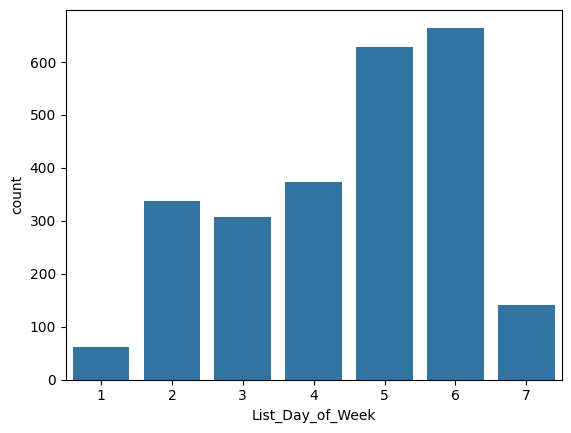

In [59]:
# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt
# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

In [60]:
df.select('LISTDATE').groupBy('LISTDATE').count().orderBy(F.desc('count')).show(3,0)

+----------+-----+
|LISTDATE  |count|
+----------+-----+
|2017-04-07|56   |
|2017-03-31|56   |
|2017-06-02|54   |
+----------+-----+
only showing top 3 rows



In [61]:
median_prices_df = spark.read.csv('./price.csv', header=True,inferSchema=True)
median_prices_df.show(3,0)
median_prices_df.printSchema()


+----------------+----+---------------+
|City            |Year|MedianHomeValue|
+----------------+----+---------------+
|MAPW - Maplewood|2016|265098         |
|MAPW - Maplewood|2017|275098         |
|WB - Woodbury   |2016|190846         |
+----------------+----+---------------+
only showing top 3 rows

root
 |-- City: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- MedianHomeValue: integer (nullable = true)



In [62]:
# from pyspark.sql.functions import year

# Initialize dataframes
real_estate_df = df
price_df = median_prices_df
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')
# Create year column
df = df.withColumn('list_year', F.year('LISTDATE'))

# Adjust year to match
df = df.withColumn('report_year', (df['list_year'] - 1))
df.select('CITY', 'report_year','list_year','LISTDATE').describe().show(7,0)

+-------+----------------+--------------------+--------------------+
|summary|CITY            |report_year         |list_year           |
+-------+----------------+--------------------+--------------------+
|count  |4946            |4946                |4946                |
|mean   |NULL            |2016.0002021835826  |2017.0002021835826  |
|stddev |NULL            |0.014219127353434618|0.014219127353434618|
|min    |LELM - Lake Elmo|2016                |2017                |
|max    |WB - Woodbury   |2017                |2018                |
+-------+----------------+--------------------+--------------------+



In [63]:
price_df.select('City', 'Year').describe().show(7,0)

+-------+----------------+------------------+
|summary|City            |Year              |
+-------+----------------+------------------+
|count  |10              |10                |
|mean   |NULL            |2016.5            |
|stddev |NULL            |0.5270462766947492|
|min    |LELM - Lake Elmo|2016              |
|max    |WB - Woodbury   |2017              |
+-------+----------------+------------------+



In [64]:
price_df = price_df.withColumnRenamed('City', 'CITY_price')
price_df = price_df.withColumnRenamed('Year', 'report_year_price')

In [65]:

# Create join condition
condition = [df['CITY'] == price_df['CITY_price'], df['report_year'] == price_df['report_year_price']]

# Join the dataframes together
df = df.join(price_df, on=condition, how='left')
df = df.drop('CITY_price', 'report_year_price')
# Inspect that new columns are available
df[['MedianHomeValue']].show(5)

+---------------+
|MedianHomeValue|
+---------------+
|         237624|
|         190846|
|         237624|
|         190846|
|         237624|
+---------------+
only showing top 5 rows



In [66]:
from pyspark.sql.functions import lag, datediff, to_date, count
from pyspark.sql.window import Window


# Initialize dataframes
mort_df = spark.read.csv('./mort_m_261.csv', header=True,inferSchema=True)
# Cast data type
mort_df = mort_df.withColumn('DATE', to_date('DATE'))

# Create window
w = Window().orderBy(mort_df['DATE'])
# Create lag column
mort_df = mort_df\
	.withColumn(
		'DATE-1',
		lag(mort_df['DATE'], 1).over(w)
	)

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', datediff('DATE', 'DATE-1'))
mort_df.show(3,0)
mort_df.orderBy(F.desc('Days_Between_Report')).show(3,0)
# Print results
mort_df.select('Days_Between_Report').distinct().orderBy(F.desc('Days_Between_Report')).show(3,0)

+----------+------------+----------+-------------------+
|DATE      |MORTGAGE30US|DATE-1    |Days_Between_Report|
+----------+------------+----------+-------------------+
|2013-11-08|3.47        |NULL      |NULL               |
|2013-11-09|3.7         |2013-11-08|1                  |
|2013-11-18|4.41        |2013-11-09|9                  |
+----------+------------+----------+-------------------+
only showing top 3 rows

+----------+------------+----------+-------------------+
|DATE      |MORTGAGE30US|DATE-1    |Days_Between_Report|
+----------+------------+----------+-------------------+
|2014-08-07|3.85        |2014-06-17|51                 |
|2015-06-28|3.62        |2015-05-24|35                 |
|2016-01-04|4.22        |2015-12-01|34                 |
+----------+------------+----------+-------------------+
only showing top 3 rows

+-------------------+
|Days_Between_Report|
+-------------------+
|51                 |
|35                 |
|34                 |
+-------------------

In [67]:
# Import needed functions
from pyspark.sql.functions import when

# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
df = df.withColumn(
    'has_attached_garage',
    (when(has_attached_garage, 1)
        .when(has_detached_garage, 0)
        .otherwise(None))
)

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=100)

+--------------------------------------------------------------------------+-------------------+
|                                                         GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------------------------------+-------------------+
|Attached Garage, Insulated Garage, Driveway - Concrete, Garage Door Opener|                  1|
|Attached Garage, Insulated Garage, Driveway - Concrete, Garage Door Opener|                  1|
|                  Attached Garage, Driveway - Concrete, Garage Door Opener|                  1|
|                  Attached Garage, Driveway - Concrete, Garage Door Opener|                  1|
|                  Attached Garage, Driveway - Concrete, Garage Door Opener|                  1|
|                  Attached Garage, Driveway - Concrete, Garage Door Opener|                  1|
|                  Attached Garage, Driveway - Concrete, Garage Door Opener|                  1|
|                  Attached Ga

In [68]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Convert string to list-like array
df = df.withColumn('garage_list', split(df['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(4,0)

+---------------------------+
|ex_garage_list             |
+---------------------------+
|Attached Garage            |
|More Parking Onsite for Fee|
|Garage Door Opener         |
|No Int Access to Dwelling  |
+---------------------------+
only showing top 4 rows



In [69]:
# ex_df = ex_df.withColumnRenamed('No.', 'NO')
# ex_df = ex_df.withColumn('NO',ex_df.NO.cast('int'))
# ex_df.show(5,0)

In [70]:
ex_df.dtypes

[('PostalCode', 'string'),
 ('NO', 'int'),
 ('MLSID', 'string'),
 ('StreetNumberNumeric', 'string'),
 ('streetaddress', 'string'),
 ('STREETNAME', 'string'),
 ('StateOrProvince', 'string'),
 ('City', 'string'),
 ('SALESCLOSEPRICE', 'double'),
 ('LISTDATE', 'date'),
 ('LISTPRICE', 'string'),
 ('LISTTYPE', 'string'),
 ('OriginalListPrice', 'string'),
 ('PricePerTSFT', 'string'),
 ('FOUNDATIONSIZE', 'double'),
 ('FENCE', 'string'),
 ('MapLetter', 'string'),
 ('LotSizeDimensions', 'string'),
 ('SchoolDistrictNumber', 'string'),
 ('DAYSONMARKET', 'double'),
 ('offmarketdate', 'string'),
 ('FIREPLACES', 'double'),
 ('RoomArea4', 'string'),
 ('roomtype', 'string'),
 ('ROOF', 'string'),
 ('RoomFloor4', 'string'),
 ('PotentialShortSale', 'string'),
 ('PoolDescription', 'string'),
 ('PDOM', 'double'),
 ('GarageDescription', 'string'),
 ('SQFTABOVEGROUND', 'double'),
 ('TAXES', 'double'),
 ('RoomFloor1', 'string'),
 ('RoomArea1', 'string'),
 ('TAXWITHASSESSMENTS', 'double'),
 ('TAXYEAR', 'double'

In [71]:
df_mid_feature = df

In [72]:
from pyspark.sql.functions import coalesce, first

ex_df = ex_df.withColumn('constant_val', F.lit(1))
# Pivot 
piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))

In [73]:
piv_df.show(3)

+----+--------+---------------+-------+---------------------+-------+---------------+------------------+-------------------+-----------------+------------------------+-----------------+------------------+-------------+----------------+----------------------------+---------------------------+-------------------------+----+----------------------+-----+-------+------+---------+----------+--------------+------------------+----------+---------------------+
|  NO|Assigned|Attached Garage|Carport|Contract Pkg Required|Covered|Detached Garage|Driveway - Asphalt|Driveway - Concrete|Driveway - Gravel|Driveway - Other Surface|Driveway - Shared|Garage Door Opener|Heated Garage|Insulated Garage|More Parking Offsite for Fee|More Parking Onsite for Fee|No Int Access to Dwelling|None|On-Street Parking Only|Other|Secured|Tandem|Tuckunder|Unassigned|Uncovered/Open|Underground Garage|Units Vary|Valet Parking for Fee|
+----+--------+---------------+-------+---------------------+-------+---------------+---

In [74]:
# df = df.withColumnRenamed('No.', 'NO')
# df = df.withColumn('NO',df.NO.cast('int'))

In [75]:
# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)
zfilled_df.show(5,0)

+----+----------+-----+-------------------+------------------+----------+---------------+-------------+---------------+----------+---------+---------------+-----------------+------------+--------------+-------+---------+-----------------+-----------------------------+------------+--------------+----------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+----------+------------------+---------------+----+--------------------------------------------------------------------------+---------------+-------+----------+---------+------------------+-------+----------+----------+---------+------------------+----------------+-----+------------------+----------------------------------------------------------------------------------------------------------------------------------------

In [76]:
df.select('List_Day_of_Week').dtypes

[('List_Day_of_Week', 'int')]

In [77]:
df = df.withColumn('List_Day_of_Week',df.List_Day_of_Week.cast('double'))

In [78]:
# Import transformer
from pyspark.ml.feature import Binarizer

df = df.drop('Listed_On_Weekend')
# Create the transformer
binarizer = Binarizer(threshold=4.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

# Verify transformation
df[['List_Day_of_Week', 'Listed_On_Weekend']].show(8,0)

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|4.0             |0.0              |
|4.0             |0.0              |
|3.0             |0.0              |
|3.0             |0.0              |
|1.0             |0.0              |
|1.0             |0.0              |
|5.0             |1.0              |
|5.0             |1.0              |
+----------------+-----------------+
only showing top 8 rows



In [79]:
sample_df = df[['BEDROOMS']].sample(False,0.5,42).toPandas()

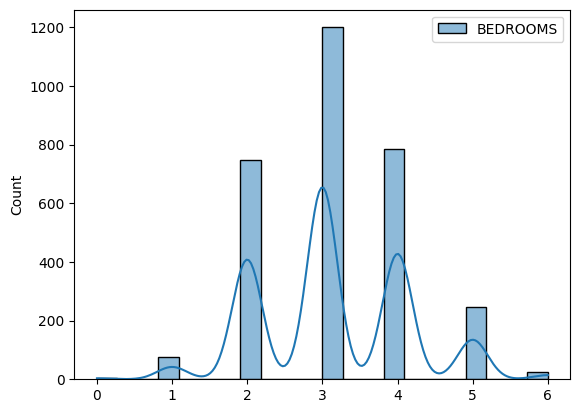

In [80]:
# Plot distribution of sample_df
sample_df = sample_df.astype({'BEDROOMS': 'double'})
sns.histplot(sample_df[['BEDROOMS']], kde=True)
plt.show()

In [81]:
from pyspark.ml.feature import Bucketizer


# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='BEDROOMS', outputCol='bedrooms')

# Apply the transformation to df: df_bucket
df_bucket = buck.transform(df)

# Display results
df_bucket[['BEDROOMS', 'bedrooms']].show(4)


+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     4.0|     4.0|
|     4.0|     4.0|
|     5.0|     5.0|
|     5.0|     5.0|
+--------+--------+
only showing top 4 rows



In [82]:
df_bucket[['BEDROOMS', 'bedrooms']].orderBy(F.desc('BEDROOMS')).show(4)

+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     5.0|     5.0|
|     5.0|     5.0|
|     5.0|     5.0|
|     5.0|     5.0|
+--------+--------+
only showing top 4 rows



In [83]:
# new_df = spark.createDataFrame([('Hello, World!',),('Hello, World!',),('Hello, World',)], ['SCHOOLDISTRICTNUMBER'])
# new_df.show(5,0)

In [84]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoder

# # Define the stages in the pipeline
# string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index', handleInvalid='keep')
# encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')

# # Define the pipeline
# pipeline = Pipeline(stages=[string_indexer, encoder])

# # Fit and transform the data
# encoded_df = pipeline.fit(new_df).transform(new_df)

# # Inspect the transformation steps
# encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].show(truncate=100)

In [85]:
# df.select('SCHOOLDISTRICTNUMBER').show(5,0)

In [86]:
# Creating list with the data
data = [("624 - White Bear Lake",), ("6 - South St. Paul",), ("832 - Mahtomedi",), 
    ("625 - St. Paul",), ("623 - Roseville",), ("622 - North St Paul-Maplewood",),
    ("833 - South Washington County",), ("834 - Stillwater",)]

# Creating RDD from the list
dfss = spark.createDataFrame(data,["SCHOOLDISTRICTNUMBER"])

dfss.show(5,0)

+---------------------+
|SCHOOLDISTRICTNUMBER |
+---------------------+
|624 - White Bear Lake|
|6 - South St. Paul   |
|832 - Mahtomedi      |
|625 - St. Paul       |
|623 - Roseville      |
+---------------------+
only showing top 5 rows



In [87]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Define the stages in the pipeline
string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index', handleInvalid='keep')
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')

# Define the pipeline
pipeline = Pipeline(stages=[string_indexer, encoder])

# Fit and transform the data
encoded_df = pipeline.fit(dfss).transform(dfss)

# Inspect the transformation steps
encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].show(truncate=100)

+-----------------------------+------------+-------------+
|         SCHOOLDISTRICTNUMBER|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|        624 - White Bear Lake|         3.0|(8,[3],[1.0])|
|           6 - South St. Paul|         0.0|(8,[0],[1.0])|
|              832 - Mahtomedi|         5.0|(8,[5],[1.0])|
|               625 - St. Paul|         4.0|(8,[4],[1.0])|
|              623 - Roseville|         2.0|(8,[2],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(8,[1],[1.0])|
|833 - South Washington County|         6.0|(8,[6],[1.0])|
|             834 - Stillwater|         7.0|(8,[7],[1.0])|
+-----------------------------+------------+-------------+



In [88]:
encoded_df.show()

+--------------------+------------+-------------+
|SCHOOLDISTRICTNUMBER|School_Index|   School_Vec|
+--------------------+------------+-------------+
|624 - White Bear ...|         3.0|(8,[3],[1.0])|
|  6 - South St. Paul|         0.0|(8,[0],[1.0])|
|     832 - Mahtomedi|         5.0|(8,[5],[1.0])|
|      625 - St. Paul|         4.0|(8,[4],[1.0])|
|     623 - Roseville|         2.0|(8,[2],[1.0])|
|622 - North St Pa...|         1.0|(8,[1],[1.0])|
|833 - South Washi...|         6.0|(8,[6],[1.0])|
|    834 - Stillwater|         7.0|(8,[7],[1.0])|
+--------------------+------------+-------------+



In [89]:
df_before_encoded = df

In [90]:
df = df.join(encoded_df.cache(),on='SCHOOLDISTRICTNUMBER',how='left')

In [91]:
df.select(encoded_df.columns).show(5,0)

+-----------------------------+------------+-------------+
|SCHOOLDISTRICTNUMBER         |School_Index|School_Vec   |
+-----------------------------+------------+-------------+
|833 - South Washington County|6.0         |(8,[6],[1.0])|
|833 - South Washington County|6.0         |(8,[6],[1.0])|
|833 - South Washington County|6.0         |(8,[6],[1.0])|
|833 - South Washington County|6.0         |(8,[6],[1.0])|
|833 - South Washington County|6.0         |(8,[6],[1.0])|
+-----------------------------+------------+-------------+
only showing top 5 rows



In [92]:

df_after_encoded = df

In [93]:
df.show(5,0)

+-----------------------------+----------+----+-----+-------------------+------------------+----------+---------------+-------------+---------------+----------+---------+---------------+-----------------+------------+--------------+-------+---------+-----------------+------------+--------------+----------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+----------+------------------+---------------+----+--------------------------------------------------------------------------+---------------+-------+----------+---------+------------------+-------+----------+----------+---------+------------------+----------------+-----+------------------+----------------------------------------------------------------------------------------------------------------------------------------

In [94]:
df.printSchema()

root
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- NO: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: string (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SALESCLOSEPRICE: double (nullable = true)
 |-- LISTDATE: date (nullable = true)
 |-- LISTPRICE: string (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: string (nullable = true)
 |-- PricePerTSFT: string (nullable = true)
 |-- FOUNDATIONSIZE: double (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- DAYSONMARKET: double (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- FIREPLACES: double (nullable = true)
 |-- RoomArea4: string (nullable = true)
 |--

In [95]:
# df = df.drop('City','latitude','longitude')
# df = df.withColumn('garage_list', F.col('garage_list').cast('string'))\
#     .withColumn('School_Vec', F.col('School_Vec').cast('string'))
# df.coalesce(1).write.format('csv').option('header','true').partitionBy('report_year').mode('overwrite').save('./tmp_feature.csv')
# df_after_encoded.coalesce(1).write.parquet('./03_Feature_Engineering_end.parquet', mode='overwrite',compression='gzip', partitionBy='report_year')

In [96]:
# from pyspark.ml.feature import OneHotEncoder, StringIndexer

# # Map strings to numbers with string indexer
# string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index')
# indexed_df = string_indexer.fit(df).transform(df)

# # Onehot encode indexed values
# encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
# encoded_df = encoder.transform(indexed_df)

# # Inspect the transformation steps
# encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].show(truncate=100)